In [1]:
#!/usr/bin/env python
import sys
sys.path.insert(0, './gym-snake/')
import gym
import time
from optparse import OptionParser
import gym_snake
from gym_snake.envs.constants import GridType, Action4, Action6
from PyQt5.QtCore import Qt

from gym import wrappers
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

__author__ = "Luksa Koch Vindbjerg"
__email__ = "201906015@post.au.dk"

is_done = False

def resetEnv(env):
    global is_done

    is_done = False
    env.reset()


# Load the gym environment
env8 = gym.make('Snake-8x8-v0')
env16 = gym.make('Snake-16x16-v0')

resetEnv(env8)
resetEnv(env16)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

register(
    id='Snake--4x4-DeadApple--v0',
    entry_point='gym_snake.envs:Snake__4x4_DeadApple_'
)
register(
    id='Snake-Hex-4x4-DeadApple--v0',
    entry_point='gym_snake.envs:Snake_Hex_4x4_DeadApple_'
)
register(
    id='Snake--8x8-DeadApple--v0',
    entry_point='gym_snake.envs:Snake__8x8_DeadApple_'
)
register(
    id='Snake-Hex-8x8-DeadApple--v0',
    entry_point='gym_snake.envs:Snake_Hex_8x8_DeadApple_'
)
register(
    id='Snake--16x16-DeadApple--v0',
    entry_point='gym_snake.envs:Snake__16x16_DeadApple_'
)
register(
    id='Snake-Hex-16x16-DeadApple--v0',
    entry_point='gym_snake.envs:Snake_Hex_16x16_DeadApple_'
)
register(
    id='Snake--4x4---v0',
    entry_point='gym_snake.envs:Snake__4x4__'
)
register(
    id='Snake-Hex-4x4---v0',
    entry_point='gym_snake.envs:Snake_Hex_4x4__'
)
register(
    id='Snake--8x8---v0',
    entry_point='gym_snake.envs:Snake__8x8__'
)
register(
    id='Snake-Hex-8x8---v0',
    entry_point='gym_snake.envs:Snake_Hex_8x8__'
)
register(
    

/home/malthet/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/malthet/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/home/malthet/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Displaying the grid

/home/malthet/anaconda3/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/home/malthet/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:280: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(
/home/malthet/anaconda3/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


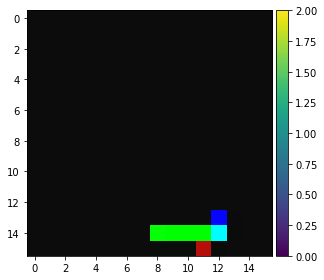

In [3]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(16, interpolation=Image.BOX),
                    T.ToTensor()])

def get_screen(fromEnv):
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = fromEnv.render(mode='rgb_array').transpose((2, 0, 1))

    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)
    # return screen.unsqueeze(0)


from skimage import io

last_screen = get_screen(env16)
env16.step(1)
current_screen = get_screen(env16)
img = current_screen + last_screen
# print(np.round(img))
io.imshow(img.squeeze(0).numpy().transpose(2, 1, 0))

    
                   

Loading CNN model

In [4]:
class old_model_architecture(nn.Module):
        def __init__(self, outputs):
            super(old_model_architecture, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
            # self.maxpool1 = nn.MaxPool2d(kernel_size=2)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding='same')
            # self.maxpool2 = nn.MaxPool2d(kernel_size=2)
            self.conv3 = nn.Conv2d(64, 64, kernel_size=5, padding='same')
            self.bn3 = nn.BatchNorm2d(64)
            self.fc1 = nn.Linear(4096, outputs)


        def forward(self, x):
            x = x.to(device)
            x = F.relu(self.conv1(x))
            # x = self.maxpool1(x)
            x = F.relu(self.conv2(x))
            # x = self.maxpool2(x)
            x = F.relu(self.conv3(x))
            x = self.bn3(x)
            x = self.fc1(x.view(x.size(0), -1))
            return x

In [5]:
""" Hyperparameters """
BATCH_SIZE = 128
GAMMA = 0.95

exploration_rate = 1.
exploration_decay = 0.9995
exploration_min = 0.01

TARGET_UPDATE = 50
learning_rate = 1e-4  
decay_rate = 0.99 
num_episodes = 500
MEMORY_SIZE = 10000

# Modifying the model

In [6]:
path_cnn = 'models/snakeaiCNN1.pkl'
# \dl-project-grp21\src\models\snakeaiCNN1.pkl

tf_model_16 = old_model_architecture(env16.action_space.n).to(device)
tf_model_16.load_state_dict(torch.load(path_cnn))
tf_model_16.eval()


tf_model_16.fc1 = nn.Linear(16384, env16.action_space.n).to(device)

target_net = old_model_architecture(env16.action_space.n).to(device)
target_net.fc1 = nn.Linear(16384, env16.action_space.n).to(device)
target_net.load_state_dict(tf_model_16.state_dict())
target_net.eval()

optimizer = optim.Adam(tf_model_16.parameters())

criterion = nn.SmoothL1Loss()


Attempting ResNet

In [7]:
""" Initialize experince memory """
memory = ReplayMemory(MEMORY_SIZE)

steps_done = 0

def select_action(state):
    global steps_done
    global exploration_rate
    exploration_rate *= exploration_decay
    exploration_rate = max(exploration_rate, exploration_min)
    steps_done += 1
    if np.random.rand() > exploration_rate:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return tf_model_16(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(env16.action_space.n)]], device=device, dtype=torch.long)

In [8]:
""" Model Optimization """

losses = []
mean_loss = []
q_values = []
q_avg_values = []

def optimize_model():

    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
                                          
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = tf_model_16(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    q_values.append(expected_state_action_values.to('cpu').detach().numpy())

    
    #print(expected_state_action_values.unsqueeze(1))
    #print(state_action_values)
    # Compute Huber loss
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    losses.append(loss.to('cpu').detach().numpy())
    mean_loss.append(np.mean(losses))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in tf_model_16.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()



/home/malthet/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/malthet/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


playing episode:  100 / 500  mean loss =>  0.002 mean reward =>  -0.97
playing episode:  200 / 500  mean loss =>  0.001 mean reward =>  -0.63
playing episode:  300 / 500  mean loss =>  0.0011 mean reward =>  1.61
playing episode:  400 / 500  mean loss =>  0.0012 mean reward =>  1.6
Complete


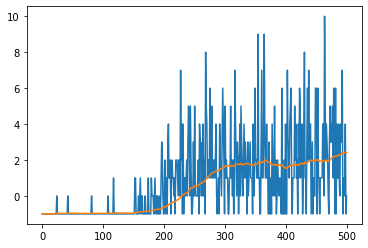

In [9]:
""" Training """

num_model = "_transfer_pretrained"
save_path = 'models/snakeai'+str(num_model)+'.pkl'

episode_reward = 0
rewards = []
moveing_average_rewards = []

for i_episode in range(num_episodes):

    episode_reward = 0

    if i_episode % 100 == 0 and i_episode != 0:
        print("playing episode: ", i_episode,"/",num_episodes, 
        " mean loss => ", round(mean_loss[-1],4),
        "mean reward => ", round(moveing_average_rewards[-1], 4))

    # Initialize the environment and state
    env16.reset()
    last_screen = get_screen(env16)
    current_screen = get_screen(env16)
    state = current_screen + last_screen


    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env16.step(action.item())
        reward = torch.tensor([reward], device=device).long()
        episode_reward += reward

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen(env16)
        if not done:
            next_state = current_screen + last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        
        if done:
            rewards.append(episode_reward.item())
            # Take the mean of the last 100 rewards
            moveing_average_rewards.append(np.mean(rewards[-100:]))

            q_avg_values.append(np.mean(q_values))
            q_values = []
            
            break

        # Update the target network, copying all weights and biases in DQN
        if t % TARGET_UPDATE == 0:
            target_net.load_state_dict(tf_model_16.state_dict())
            torch.save(tf_model_16.state_dict(), save_path)

print('Complete')
env16.close()
plt.plot(rewards)
plt.plot(moveing_average_rewards)
plt.ioff()
plt.show()

# 28:40

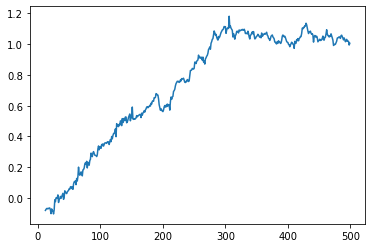

In [10]:
plt.plot(q_avg_values)
np.savetxt("transfer_pretrained_rewards.csv", rewards)
np.savetxt("transfer_pretrained_q.csv", q_avg_values)
np.savetxt("transfer_pretrained_loss.csv", losses)

In [11]:
training = False

if(not training):

    num_episodes = 10

    env16 = gym.wrappers.RecordVideo(env16, 'video/transfer_pretrained', episode_trigger = lambda x: x % 1 == 0)

    episode_reward = 0
    rewards = []

    for i_episode in range(num_episodes):

        # Initialize the environment and state
        env16.reset()
        last_screen = get_screen(env16)
        current_screen = get_screen(env16)
        state = current_screen + last_screen

        for t in count():
            # Select and perform an action
            action = tf_model_16(state).max(1)[1].view(1, 1)
            _, reward, done, _ = env16.step(action.item())
            reward = torch.tensor([reward], device=device)
            episode_reward += reward

            # Observe new state
            last_screen = current_screen
            current_screen = get_screen(env16)
            if not done:
                next_state = current_screen + last_screen
            else:
                next_state = None

            # Move to the next state
            state = next_state

            if done:
                rewards.append(episode_reward.item())
                break